In [20]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset,TensorDataset
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as tt
import json
import re
import string
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import Vocab
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# importing torch.optim and torch.nn.functional
import torch.optim as optim
from sklearn import datasets

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
#from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

print(torch.__version__)
print(torchvision.__version__)

# Create a SummaryWriter
writer = SummaryWriter()

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
device

2.0.1
0.15.1


device(type='mps')

In [21]:
COUPLING_DIM = 256
COUPLING_LAYERS = 2
INPUT_DIM = 2
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 300

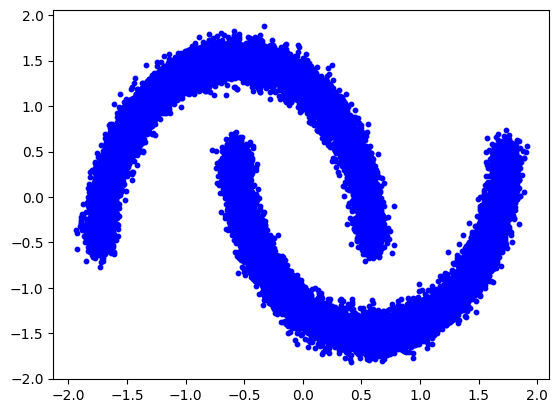

In [22]:
data = datasets.make_moons(n_samples=30000, noise=.05)[0].astype(np.float32)

scaler = StandardScaler()
data = scaler.fit_transform(data)

# converting to torch tensor
normalized_data = torch.from_numpy(data)

# plotting it on a scatter

plt.scatter(normalized_data[:, 0], normalized_data[:, 1], s=10, c='b')
plt.show()


In [23]:
class Coupling(nn.Module):
    def __init__(self, input_dim, coupling_dim, reg):
        super(Coupling, self).__init__()
        self.input_dim = input_dim
        self.coupling_dim = coupling_dim
        self.reg = reg
        
        self.s_layer_1 = nn.Linear(input_dim, coupling_dim)
        self.s_layer_2 = nn.Linear(coupling_dim, coupling_dim)
        self.s_layer_3 = nn.Linear(coupling_dim, coupling_dim)
        self.s_layer_4 = nn.Linear(coupling_dim, coupling_dim)
        self.s_layer_5 = nn.Linear(coupling_dim, input_dim)

        self.t_layer_1 = nn.Linear(input_dim, coupling_dim)
        self.t_layer_2 = nn.Linear(coupling_dim, coupling_dim)
        self.t_layer_3 = nn.Linear(coupling_dim, coupling_dim)
        self.t_layer_4 = nn.Linear(coupling_dim, coupling_dim)
        self.t_layer_5 = nn.Linear(coupling_dim, input_dim)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        s_layer_1_out = self.relu(self.s_layer_1(x))
        s_layer_2_out = self.relu(self.s_layer_2(s_layer_1_out))
        s_layer_3_out = self.relu(self.s_layer_3(s_layer_2_out))
        s_layer_4_out = self.relu(self.s_layer_4(s_layer_3_out))
        s_layer_5_out = self.tanh(self.s_layer_5(s_layer_4_out))

        t_layer_1_out = self.relu(self.t_layer_1(x))
        t_layer_2_out = self.relu(self.t_layer_2(t_layer_1_out))
        t_layer_3_out = self.relu(self.t_layer_3(t_layer_2_out))
        t_layer_4_out = self.relu(self.t_layer_4(t_layer_3_out))
        t_layer_5_out = self.t_layer_5(t_layer_4_out)

        return s_layer_5_out, t_layer_5_out
    
    def weight_decay_loss(self):
        l2_reg = torch.tensor(0.0)
        for name, param in self.named_parameters():
            if 'weight' in name:
                l2_reg += torch.norm(param, p=2)
        return self.reg * l2_reg



In [59]:
class RealNVP(nn.Module):
    def __init__(self, input_dim, coupling_layers, coupling_dim, regularization):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.zeros(input_dim), torch.eye(input_dim)
        )
        self.masks = torch.tensor(
            [[0, 1], [1, 0]] * (coupling_layers // 2), dtype=torch.float32
        ).to(device)
        self.loss_tracker = nn.MSELoss()
        self.layers_list = nn.ModuleList([
            Coupling(input_dim, coupling_dim, regularization)
            for i in range(coupling_layers)
        ])

    def forward(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * torch.exp(direction * s) + direction * t * torch.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * torch.sum(s, dim=1)
        return x, log_det_inv


In [60]:
model = RealNVP(INPUT_DIM, COUPLING_LAYERS, COUPLING_DIM, REGULARIZATION)
model = model.to(device)

In [79]:
def log_loss(model, x):
    x = x.to(device)
    
    y, logdet = model(x)
    log_likelihood = model.distribution.log_prob(y) + logdet
    return -torch.mean(log_likelihood).to(device)

loss_fn = log_loss()

TypeError: log_loss() missing 2 required positional arguments: 'model' and 'x'

In [96]:

from torch.utils.tensorboard import SummaryWriter

class ImageGenerator:
    def __init__(self, num_samples):
        self.num_samples = num_samples
        self.writer = SummaryWriter()  # TensorBoard writer

    def generate(self):
        # From data to latent space.
        z, _ = model(normalized_data)

        # putting normalized_data to device
        normalized_data = normalized_data.to(device)

        # From latent space to data.
        samples = model.distribution.sample((self.num_samples,))
        x, _ = model(samples)

        return x.detach().numpy(), z.detach().numpy(), samples.detach().numpy()

    def display(self, x, z, samples, epoch, save_to=None):
        f, axes = plt.subplots(2, 2)
        f.set_size_inches(8, 5)

        axes[0, 0].scatter(
            normalized_data[:, 0], normalized_data[:, 1], color="r", s=1
        )
        axes[0, 0].set(title="Data space X", xlabel="x_1", ylabel="x_2")
        axes[0, 0].set_xlim([-2, 2])
        axes[0, 0].set_ylim([-2, 2])
        axes[0, 1].scatter(z[:, 0], z[:, 1], color="r", s=1)
        axes[0, 1].set(title="f(X)", xlabel="z_1", ylabel="z_2")
        axes[0, 1].set_xlim([-2, 2])
        axes[0, 1].set_ylim([-2, 2])
        axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g", s=1)
        axes[1, 0].set(title="Latent space Z", xlabel="z_1", ylabel="z_2")
        axes[1, 0].set_xlim([-2, 2])
        axes[1, 0].set_ylim([-2, 2])
        axes[1, 1].scatter(x[:, 0], x[:, 1], color="g", s=1)
        axes[1, 1].set(title="g(Z)", xlabel="x_1", ylabel="x_2")
        axes[1, 1].set_xlim([-2, 2])
        axes[1, 1].set_ylim([-2, 2])

        plt.savefig("image.png")
        image = plt.imread("image.png")
        image = torch.from_numpy(image.transpose((2, 0, 1))) # HWC to CHW
        self.writer.add_image("Generated Image", image, epoch)

        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        if save_to:
            plt.savefig(save_to)
            print(f"\nSaved to {save_to}")

        plt.show()

In [73]:
dataset = TensorDataset(normalized_data)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [74]:
# setting optimizer
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Create an instance of ImageGenerator
image_generator = ImageGenerator(num_samples=1000)

In [77]:
model = model.to(device)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    for batch in data_loader:
        x = batch[0].to(device)
        loss = loss_fn(model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation and image generation at every epoch
    model.eval()
    with torch.no_grad():
        loss = model.log_loss(normalized_data.to(device))
    print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # Generate and log image
    x, z, samples = image_generator.generate()
    image_generator.display(x, z, samples, epoch)

    # Save model checkpoint every 50 epochs
    if epoch % 50 == 0:
        torch.save(model.state_dict(), f"model_checkpoint_epoch_{epoch}.pth")

NameError: name 'loss_fn' is not defined

## Model V2

https://github.com/xqding/RealNVP/blob/master/Real%20NVP%20Tutorial.ipynb

In [86]:
import torch.nn.init as init
class Affine_Coupling(nn.Module):
    def __init__(self, mask, hidden_dim):
        super(Affine_Coupling, self).__init__()
        self.input_dim = len(mask)
        self.hidden_dim = hidden_dim

        ## mask to seperate positions that do not change and positions that change.
        ## mask[i] = 1 means the ith position does not change.
        self.mask = nn.Parameter(mask, requires_grad = False)

        ## layers used to compute scale in affine transformation
        self.scale_fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.scale_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.scale_fc3 = nn.Linear(self.hidden_dim, self.input_dim)
        self.scale = nn.Parameter(torch.Tensor(self.input_dim))
        init.normal_(self.scale)

        ## layers used to compute translation in affine transformation 
        self.translation_fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.translation_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.translation_fc3 = nn.Linear(self.hidden_dim, self.input_dim)

    def _compute_scale(self, x):
        ## compute scaling factor using unchanged part of x with a neural network
        s = torch.relu(self.scale_fc1(x*self.mask))
        s = torch.relu(self.scale_fc2(s))
        s = torch.relu(self.scale_fc3(s)) * self.scale        
        return s

    def _compute_translation(self, x):
        ## compute translation using unchanged part of x with a neural network        
        t = torch.relu(self.translation_fc1(x*self.mask))
        t = torch.relu(self.translation_fc2(t))
        t = self.translation_fc3(t)        
        return t
    
    def forward(self, x):
        ## convert latent space variable to observed variable
        s = self._compute_scale(x)
        t = self._compute_translation(x)
        
        y = self.mask*x + (1-self.mask)*(x*torch.exp(s) + t)        
        logdet = torch.sum((1 - self.mask)*s, -1)
        
        return y, logdet

    def inverse(self, y):
        ## convert observed varible to latent space variable
        s = self._compute_scale(y)
        t = self._compute_translation(y)
                
        x = self.mask*y + (1-self.mask)*((y - t)*torch.exp(-s))
        logdet = torch.sum((1 - self.mask)*(-s), -1)
        
        return x, logdet

In [87]:
class RealNVP_2D(nn.Module):
    '''
    A vanilla RealNVP class for modeling 2 dimensional distributions
    '''
    def __init__(self, masks, hidden_dim):
        '''
        initialized with a list of masks. each mask define an affine coupling layer
        '''
        super(RealNVP_2D, self).__init__()        
        self.hidden_dim = hidden_dim        
        self.masks = nn.ParameterList(
            [nn.Parameter(torch.Tensor(m),requires_grad = False)
             for m in masks])

        self.affine_couplings = nn.ModuleList(
            [Affine_Coupling(self.masks[i], self.hidden_dim)
             for i in range(len(self.masks))])
        
    def forward(self, x):
        ## convert latent space variables into observed variables
        y = x
        logdet_tot = 0
        for i in range(len(self.affine_couplings)):
            y, logdet = self.affine_couplings[i](y)
            logdet_tot = logdet_tot + logdet

        ## a normalization layer is added such that the observed variables is within
        ## the range of [-4, 4].
        logdet = torch.sum(torch.log(torch.abs(4*(1-(torch.tanh(y))**2))), -1)        
        y = 4*torch.tanh(y)
        logdet_tot = logdet_tot + logdet
        
        return y, logdet_tot

    def inverse(self, y):
        ## convert observed variables into latent space variables        
        x = y        
        logdet_tot = 0

        # inverse the normalization layer
        logdet = torch.sum(torch.log(torch.abs(1.0/4.0* 1/(1-(x/4)**2))), -1)
        x  = 0.5*torch.log((1+x/4)/(1-x/4))
        logdet_tot = logdet_tot + logdet

        ## inverse affine coupling layers
        for i in range(len(self.affine_couplings)-1, -1, -1):
            x, logdet = self.affine_couplings[i].inverse(x)
            logdet_tot = logdet_tot + logdet
            
        return x, logdet_tot

In [ ]:
## Masks used to define the number and the type of affine coupling layers
## In each mask, 1 means that the variable at the correspoding position is
## kept fixed in the affine couling layer
masks = [[1.0, 0.0],
         [0.0, 1.0],
         [1.0, 0.0],         
         [0.0, 1.0],
         [1.0, 0.0],         
         [0.0, 1.0],
         [1.0, 0.0],
         [0.0, 1.0]]

## dimenstion of hidden units used in scale and translation transformation
hidden_dim = 128

## construct the RealNVP_2D object
realNVP = RealNVP_2D(masks, hidden_dim)

 20%|█▉        | 999/5000 [04:43<20:21,  3.28it/s]

idx_steps: 999, loss: 0.48881


 40%|███▉      | 1999/5000 [09:13<12:48,  3.90it/s]

idx_steps: 1999, loss: 0.43452


 60%|█████▉    | 2999/5000 [13:41<09:59,  3.34it/s]

idx_steps: 2999, loss: 0.38259


 80%|███████▉  | 3999/5000 [18:29<04:28,  3.73it/s]

idx_steps: 3999, loss: 0.27972


100%|█████████▉| 4999/5000 [23:11<00:00,  3.25it/s]

idx_steps: 4999, loss: 0.35634


100%|██████████| 5000/5000 [23:11<00:00,  3.59it/s]


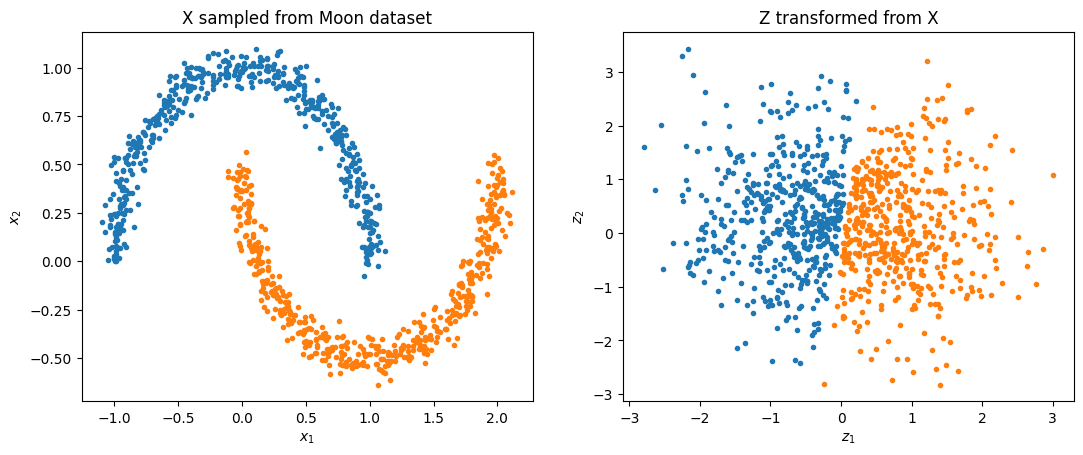

In [94]:
from torch.utils.tensorboard import SummaryWriter
import math
from tqdm import tqdm

# Create a SummaryWriter instance for TensorBoard
writer = SummaryWriter()

num_steps = 5000

for idx_step in tqdm(range(num_steps)):
    X, label = datasets.make_moons(n_samples = 512, noise = 0.05)
    X = torch.Tensor(X).to(device = device)

    z, logdet = realNVP.inverse(X)

    loss = torch.log(z.new_tensor([2*math.pi])) + torch.mean(torch.sum(0.5*z**2, -1) - logdet)
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

    if (idx_step + 1) % 1000 == 0:
        print(f"idx_steps: {idx_step:}, loss: {loss.item():.5f}")

    # Save images to TensorBoard every epoch
    if (idx_step + 1) % 1 == 0:
        X, label = datasets.make_moons(n_samples = 1000, noise = 0.05)
        X = torch.Tensor(X).to(device = device)
        z, logdet_jacobian = realNVP.inverse(X)
        z = z.cpu().detach().numpy()

        X = X.cpu().detach().numpy()
        fig = plt.figure(2, figsize = (12.8, 4.8))
        fig.clf()
        plt.subplot(1,2,1)
        plt.plot(X[label==0,0], X[label==0,1], ".")
        plt.plot(X[label==1,0], X[label==1,1], ".")
        plt.title("X sampled from Moon dataset")
        plt.xlabel(r"$x_1$")
        plt.ylabel(r"$x_2$")

        plt.subplot(1,2,2)
        plt.plot(z[label==0,0], z[label==0,1], ".")
        plt.plot(z[label==1,0], z[label==1,1], ".")
        plt.title("Z transformed from X")
        plt.xlabel(r"$z_1$")
        plt.ylabel(r"$z_2$")
        plt.savefig("image.png")
        image = plt.imread("image.png")
        image = torch.from_numpy(image.transpose((2, 0, 1))) # HWC to CHW
        writer.add_image("Generated Image", image, idx_step)

    # Save model checkpoint every 50 epochs
    if (idx_step + 1) % 50 == 0:
        torch.save(realNVP.state_dict(), f"realNVP_checkpoint_step_{idx_step}.pth")

plt.show()

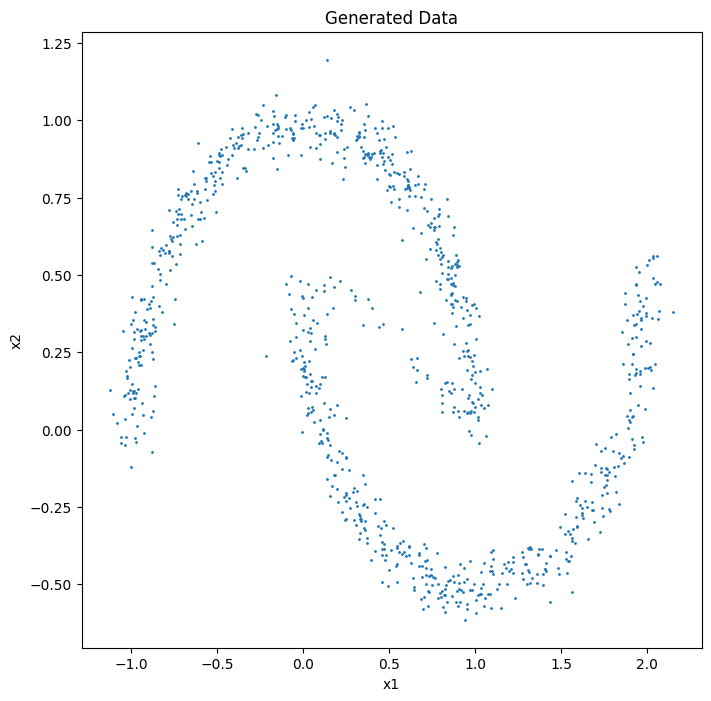

In [98]:
num_samples = 1000  # Number of samples to generate

# Sample from the latent space
z = torch.randn(num_samples, 2).to(device)  # Assuming your latent space is 2-dimensional

# Transform the samples to the data space
with torch.no_grad():
    X, _ = realNVP.forward(z)

# Move the data to CPU and convert to numpy for plotting
X = X.cpu().numpy()

# Plot the generated data
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], s=1)
plt.title("Generated Data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

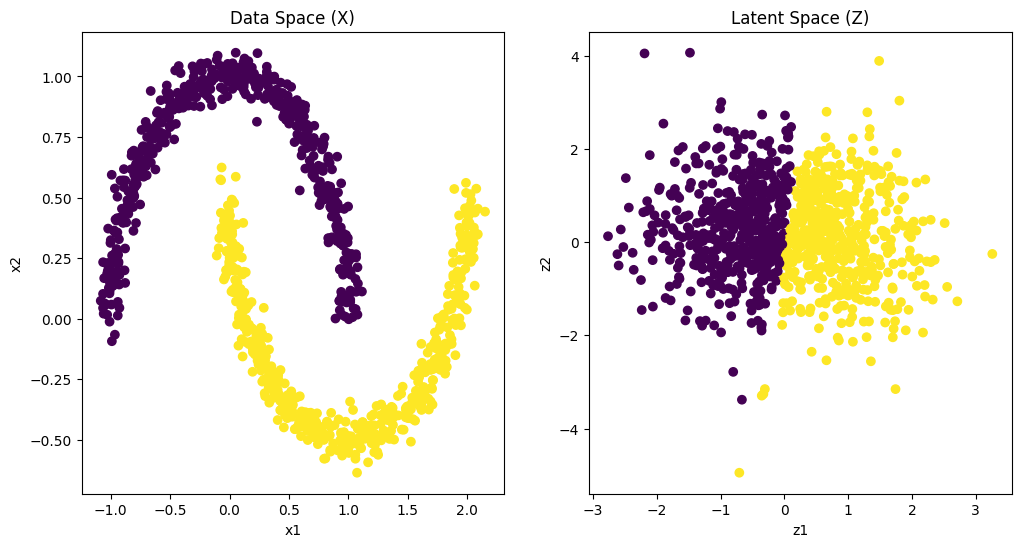

In [101]:
# Generate some samples from the data space (X)
X, label = datasets.make_moons(n_samples=1000, noise=0.05)
X = torch.Tensor(X).to(device=device)

# Transform the samples to the latent space (Z)
Z, _ = realNVP.inverse(X)

# Visualize the transformation from X to Z
X = X.cpu().detach().numpy()
Z = Z.cpu().detach().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=label, cmap='viridis')
plt.title('Data Space (X)')
plt.xlabel('x1')
plt.ylabel('x2')

plt.subplot(1, 2, 2)
plt.scatter(Z[:, 0], Z[:, 1], c=label, cmap='viridis')
plt.title('Latent Space (Z)')
plt.xlabel('z1')
plt.ylabel('z2')

plt.show()

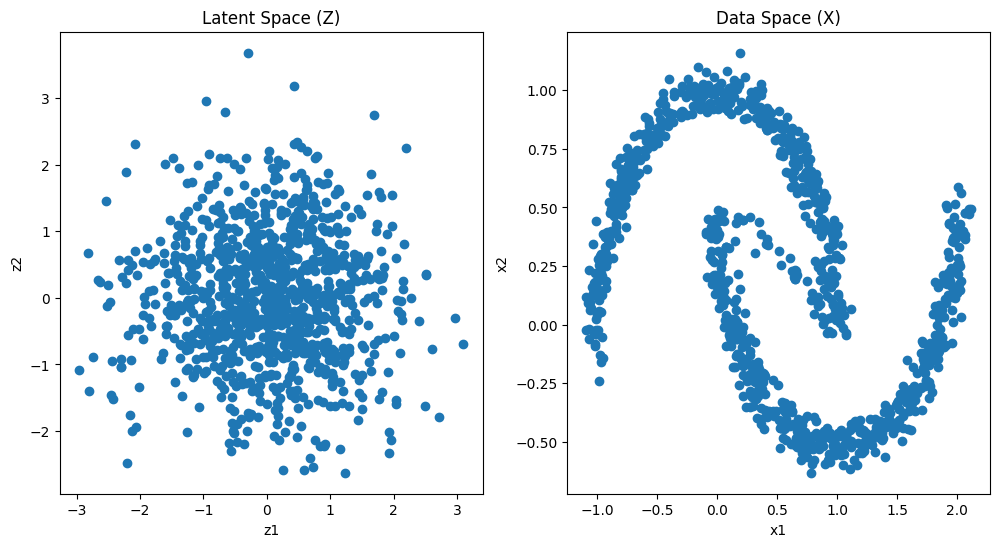

In [100]:
# Now, let's generate some samples from the latent space and transform them back to the data space
Z = torch.randn(1000, 2).to(device=device)  # Sample from standard normal distribution
X, _ = realNVP.forward(Z)

# Visualize the transformation from Z to X
Z = Z.cpu().detach().numpy()
X = X.cpu().detach().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(Z[:, 0], Z[:, 1])
plt.title('Latent Space (Z)')
plt.xlabel('z1')
plt.ylabel('z2')

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1])
plt.title('Data Space (X)')
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()